In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pickle, pprint
import csv

from scipy.stats import pearsonr
from scipy.spatial import distance
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import quantile_transform

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
def mat_ocurr(X_corrs, y_corrs):
    """Generar np.array de ocurrencias
    Toma cada palabra de la matriz de ocurrencias en la pregunta y devuelve la suma de las ocurrencias de las palabras en las respuestas correctas.
    Esto da un conteo de la palabra de la pregunta y sus palabras co-ocurrentes en las respuestas.
    X_corrs=ocurrencias de las palabras en las preguntas
    y_corrs=ocurrencias de las palabras en las respuestas
    """
    y_emb_2=[]
    for quest in range(X_corrs.shape[1]):
        y_pfil=y_corrs[X_corrs[:,quest]==1].sum(axis=0)
        y_emb_2.append(y_pfil)
    y_emb_2=np.array(y_emb_2)
    return y_emb_2

def preg_expect(preg,y_emb_2):
    """Generar np.array de probabilidades de expectativas
    Toma para cada palabra ocurrente en la pregunta y busca sus palabras co-ocurrentes, se toman las palabras ocurrentes en la pregunta y se obtienen todas las sumas de las palabras esperadas en las respuestas. Esta suma se normaliza al minimax para tener una propbabilidad de ocurrencia de palabras en la respuesta para esa combinación de palabras en la pregunta, lo cual da la expectativa (probabilidad) de las palabras en la respuesta.
    preg=embedding de ocurrencias de las palabras en la pregunta
    y_emb_2=ocurrencias de las palabras en la respuesta por cada palabra en la pregunta (salida de mat_ocurr)
    """
    y_embd_3=[]
    for ith,word in enumerate(preg):#X_dat_corr[sample]):
        if word>0:
            y_embd_3.append(y_emb_2[ith])# OJO Embedding de frecuencias
    y_embd_3=np.array(y_embd_3)
    y_embd_3=y_embd_3.sum(axis=0)
#     y_embd_3=(y_embd_3-min(y_embd_3))/(max(y_embd_3)-min(y_embd_3))#Normalización minimax#y_embd_3/max(y_embd_3)#cuando min=0 solo se divide sobre max() 
#     y_embd_3=quantile_transform(y_embd_3.reshape(-1, 1),copy=False)#.toarray()# Centil transformation uniform distribution
    y_embd_3=quantile_transform(y_embd_3.reshape(-1, 1),copy=False, output_distribution='normal')#.toarray()# Centil transformation uniform distribution
    return y_embd_3/y_embd_3.max()

def dists_resp(preg_emb, resp_emb, expect_emb):
    """Generar distancias entre la expectativa y la respuesta
    Toma para cada palabra ocurrente en la pregunta y busca sus palabras co-ocurrentes, se toman las palabras ocurrentes en la pregunta y se obtienen todas las sumas de las palabras esperadas en las respuestas. Esta suma se normaliza al minimax para tener una propbabilidad de ocurrencia de palabras en la respuesta para esa combinación de palabras en la pregunta, lo cual da la expectativa (probabilidad) de las palabras en la respuesta.
    preg_emb=embedding de ocurrencias de las palabras en la pregunta
    resp_emb=embedding de ocurrencias de las palabras en la respuesta
    expect_emb=np.array de las expectativas de las palabras en la respuesta
    
    returns distancia coseno , distancia euclideana
    """
    x_in=(preg_emb>0)*1# validar que son ocurrencias
    real=(resp_emb>0)*1# validar que son ocurrencias
    if sum(real)==0:
        real[np.random.randint(0,(len(real)),8)]=1# imputación de respuesta palabras aleatorias en caso de no tener ocurrencias en el embedding de respuestas. 8 es la mediana de la longitud de las respuestas
    pred=expect_emb
    
    real_w=real[real>0]
    pred_w=pred[real>0]
    cosine=distance.cosine(real_w,pred_w)
    euclidean=distance.euclidean(real_w,pred_w)
#     pearson=distance.correlation(real_w,pred_w)#pearsonr(real_w,pred_w)
    return cosine,euclidean#,pearson

In [3]:
# =pd.read_csv(".csv", sep=";",index_col=0)
train_questions=pd.read_csv("train_questions.csv", sep=";",index_col=0)
train_ref_ans=pd.read_csv("train_ref_ans.csv", sep=";",index_col=0)
train_stud_ans=pd.read_csv("train_stud_ans.csv", sep=";",index_col=0)
test_questions=pd.read_csv("test_questions.csv", sep=";",index_col=0)
test_ref_ans=pd.read_csv("test_ref_ans.csv", sep=";",index_col=0)
test_stud_ans=pd.read_csv("test_stud_ans.csv", sep=";",index_col=0)

train_answers=pd.read_csv("train_answers.csv", sep=";",index_col=0)
test_answers=pd.read_csv("test_answers.csv", sep=";",index_col=0)

In [4]:
# test_divs=['TEST Beetle Unseen Answers',
#            'TEST Beetle Unseen Questions',
#            'TEST sciEntsBank Unseen Answers',
#            'TEST sciEntsBank Unseen Questions',
#            'TEST sciEntsBank Unseen Domains']

test_divs=['TEST Beetle Unseen Answers',
           'TEST sciEntsBank Unseen Answers']
test_answers=test_answers[(test_answers['dtset'] == "TEST Beetle Unseen Answers") | (test_answers['dtset'] == "TEST sciEntsBank Unseen Answers")]

In [5]:
test_answers.head()

,dtset,qtype,stype,quest_id,question,ref_ans,st_answ,id_st,st_ans_calif
0,TEST sciEntsBank Unseen Answers,NaN,NaN,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",We evaporated the water.,EM.45b.299.1,1
1,TEST sciEntsBank Unseen Answers,NaN,NaN,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",We poured just the water into another thing an...,EM.45b.387.1,1
2,TEST sciEntsBank Unseen Answers,NaN,NaN,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",We kept the salt in the vial and put the water...,EM.45b.452.1,0
3,TEST sciEntsBank Unseen Answers,NaN,NaN,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Get all the water out.,EM.45b.533.1,0
4,TEST sciEntsBank Unseen Answers,NaN,NaN,EM_45c,You used several methods to separate and ident...,The crystals were square with Xs on the surface.,Well because we broke them apart.,EM.45c.340.1,0


## Explore Data

In [6]:
for dt_set in [train_answers,test_answers]:#train_questions,train_ref_ans,train_stud_ans,test_questions,test_ref_ans,test_stud_ans,
    print("***********************************************************************")
    print(dt_set.columns)
    print(dt_set.info())
#     print(dt_set.head())

***********************************************************************
Index(['dtset', 'qtype', 'stype', 'quest_id', 'question', 'ref_ans', 'st_answ',
       'id_st', 'st_ans_calif'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22167 entries, 0 to 22166
Data columns (total 9 columns):
dtset           22167 non-null object
qtype           17198 non-null object
stype           17198 non-null object
quest_id        22167 non-null object
question        22167 non-null object
ref_ans         22167 non-null object
st_answ         22167 non-null object
id_st           22167 non-null object
st_ans_calif    22167 non-null int64
dtypes: int64(1), object(8)
memory usage: 1.7+ MB
None
***********************************************************************
Index(['dtset', 'qtype', 'stype', 'quest_id', 'question', 'ref_ans', 'st_answ',
       'id_st', 'st_ans_calif'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402 entries, 0 to 7696
Data col

Baseline: 
http://homepages.inf.ed.ac.uk/mdzikovs/papers/dzikovska-naacl2012.pdf

# 3.2  Lexical similarity baseline
To   provide   a   higher   baseline   that   is   comparable   across   both   subsets   of   the   data,   we   built a  simple  decision  tree  classifier  using  the  Weka 3.6.2 implementation of C4.5 pruned decision trees (weka.classifiers.trees.J48  class),  with  default  parameters. As  features,  we  used  lexical  similarity scores computed by theText::Similarity package with default parameters. The code computes  four similarity  metrics  –  the  raw  number  ofoverlapping words, F1 score, Lesk score and cosine score.  We compared the learner response to the expected answer(s) and the question, resulting in eight total features (the four values indicated above for the comparison with the question and the highest of each value from the comparisons with each possible expected answer).

This baseline is based on the lexical overlap baseline used in RTE tasks (Bentivogli et al., 2009). However, we measured overlap with the question text in addition to the overlap with the expected answers. Students often repeat parts of the question in their answer and this needs to be taken into account to differentiate, for example, “partially correct incomplete” and “correct” answers.

# Preprocessing data

In [7]:
train_texts=pd.concat([train_questions.question,
                       train_ref_ans.ref_ans,
                       train_stud_ans.st_answ],
                      ignore_index=True)
# test_texts=pd.concat([test_questions.question,
#                       test_ref_ans.ref_ans,
#                       test_stud_ans.st_answ], 
#                       ignore_index=True)

## tf-idf matrix

In [8]:
# text_tfidf= Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer())
# ])
# txt_tfidf=text_tfidf.fit(train_texts) #  Matriz tf-idf con textos de train solamente

vectorizer = CountVectorizer(binary=True)# binary
txt_tfidf=vectorizer.fit(train_texts) #  Matriz tf con textos de train solamente

In [9]:
train_answers_correct=train_answers[train_answers.st_ans_calif==1]
tot_ans=train_answers_correct.st_answ.shape[0]

## Preprocessing Informative Embedding  

In [10]:
# X=Pregunta
# y=respuesta de referencia o respuesta correcta del estudiante
train_preg_index=[]
train_preg_ref_X_info=[]
train_preg_ref_y_info=[]
for ith_ans in range(train_answers_correct.st_answ.shape[0]):
    train_quest=txt_tfidf.transform([train_answers_correct.question.iloc[ith_ans]]).toarray()[0]
    train_ref_ans=txt_tfidf.transform([train_answers_correct.ref_ans.iloc[ith_ans]]).toarray()[0]
    train_preg_ref_X_info.append(train_quest)
    train_preg_ref_y_info.append(train_ref_ans)
    train_preg_index.append(ith_ans)
    train_std_ans=txt_tfidf.transform([train_answers_correct.st_answ.iloc[ith_ans]]).toarray()[0]
    train_preg_ref_X_info.append(train_quest)
    train_preg_ref_y_info.append(train_std_ans)
    train_preg_index.append(ith_ans)
train_preg_ref_X_info=np.array(train_preg_ref_X_info)
train_preg_ref_y_info=np.array(train_preg_ref_y_info)

In [11]:
# X=Respuesta de referencia
# y=respuesta correcta del estudiante

train_refans_index=[]
train_refans_respescorr_X_info=[]
train_refans_respescorr_y_info=[]
for ith_ans in range(train_answers_correct.st_answ.shape[0]):
    train_ref_ans=txt_tfidf.transform([train_answers_correct.ref_ans.iloc[ith_ans]]).toarray()[0]
    train_refans_respescorr_X_info.append(train_ref_ans)
    train_std_ans=txt_tfidf.transform([train_answers_correct.st_answ.iloc[ith_ans]]).toarray()[0]
    train_refans_respescorr_y_info.append(train_std_ans)
    train_refans_index.append(ith_ans)
train_refans_respescorr_X_info=np.array(train_preg_ref_X_info)
train_refans_respescorr_y_info=np.array(train_preg_ref_y_info)

In [12]:
train_refans_respescorr_X_info=train_refans_respescorr_X_info.astype("uint8", copy=False)
train_refans_respescorr_y_info=train_refans_respescorr_y_info.astype("uint8", copy=False)
train_preg_ref_X_info=train_preg_ref_X_info.astype("uint8", copy=False)
train_preg_ref_y_info=train_preg_ref_y_info.astype("uint8", copy=False)

In [13]:
output = open('train_refans_respestcorr_X_info.pkl', 'wb')
pickle.dump(train_preg_ref_X_info, output)# Pickle dictionary using protocol 0.
output.close()

output = open('train_refans_respestcorr_y_info.pkl', 'wb')
pickle.dump(train_preg_ref_y_info, output)# Pickle dictionary using protocol 0.
output.close()

In [14]:
# pkl_file = open('train_refans_respestcorr_X_info.pkl', 'rb')
# # pkl_file = open('word_train_preg_resps_X_info_tf.pkl', 'rb')
# train_preg_ref_X_info = pickle.load(pkl_file)
# pprint.pprint(train_preg_ref_X_info)
# pkl_file.close()

# pkl_file = open('train_refans_respestcorr_y_info.pkl', 'rb')
# # pkl_file = open('word_train_preg_resps_y_info_tf.pkl', 'rb')
# train_preg_ref_y_info = pickle.load(pkl_file)
# pprint.pprint(train_preg_ref_y_info)
# pkl_file.close()

In [15]:
y_emb_ocurrs_preg_resp=mat_ocurr(train_preg_ref_X_info, train_preg_ref_y_info)
y_emb_ocurrs_refans_respest=mat_ocurr(train_refans_respescorr_X_info, train_refans_respescorr_y_info)

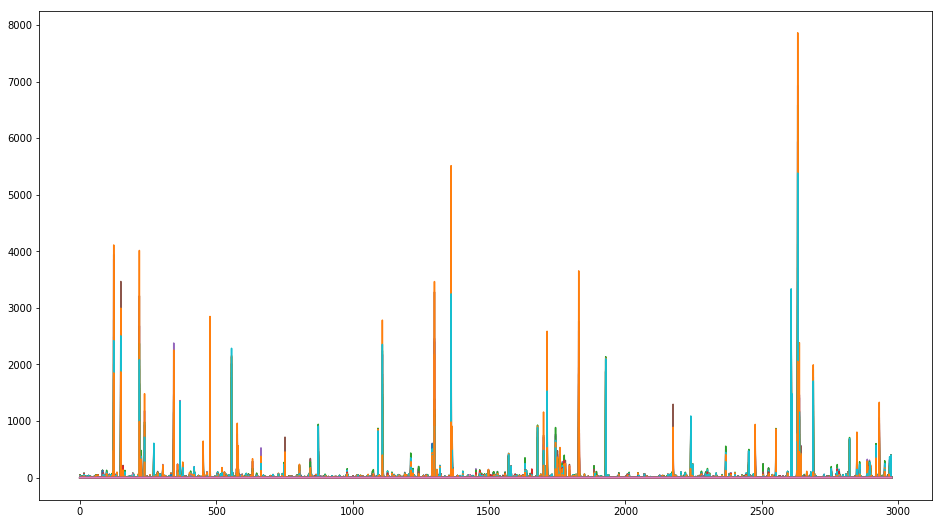

In [16]:
colormap = cm.Set1.colors

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)
for ith,ans_emb in enumerate(y_emb_ocurrs_preg_resp):
    ax.plot(ans_emb,label=ith)#x=range(len(ans_emb)),
#                 y=ans_emb) #Pregunta
# plt.legend()
plt.show()

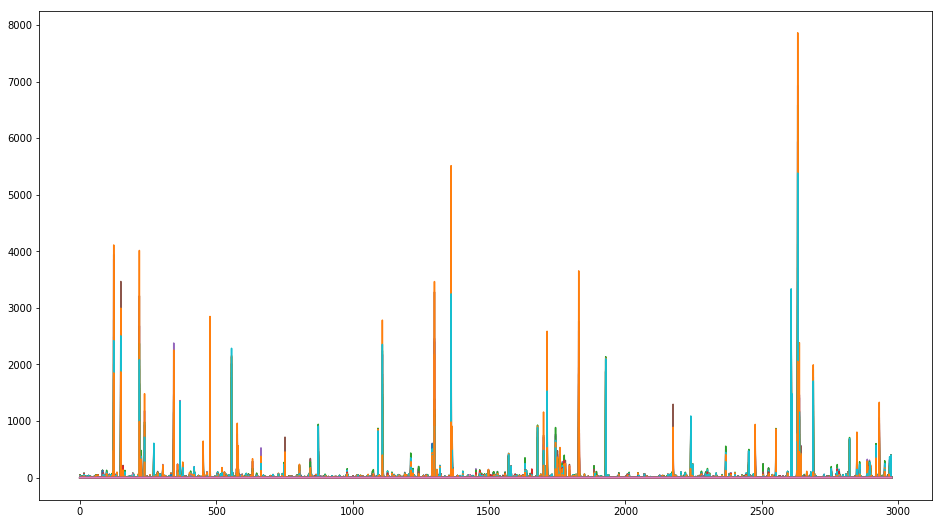

In [18]:
colormap = cm.Set1.colors

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)
for ith,ans_emb in enumerate(y_emb_ocurrs_refans_respest):
    ax.plot(ans_emb,label=ith)#x=range(len(ans_emb)),
#                 y=ans_emb) #Pregunta
# plt.legend()
plt.show()

In [19]:
## y_emb_ocurrs_preg_resp=mat_ocurr(train_preg_ref_X_info, train_preg_ref_y_info)
## y_emb_ocurrs_refans_respest=mat_ocurr(train_refans_respescorr_X_info, train_refans_respescorr_y_info)

output = open('coocurrencias_preg_respestcorr_X_info.pkl', 'wb')
pickle.dump(y_emb_ocurrs_preg_resp, output)# Pickle dictionary using protocol 0.
output.close()

output = open('coocurrencias_refans_respestcorr_X_info.pkl', 'wb')
pickle.dump(y_emb_ocurrs_refans_respest, output)# Pickle dictionary using protocol 0.
output.close()

In [20]:
# pkl_file = open('coocurrencias_refans_respestcorr_X_info.pkl', 'rb')
# y_emb_ocurrs = pickle.load(pkl_file)
# pprint.pprint(train_preg_ref_X_info)
# pkl_file.close()

In [21]:
calif=train_answers.st_ans_calif
X_dat_preg=txt_tfidf.transform(train_answers.question).toarray()
X_dat_refans=txt_tfidf.transform(train_answers.ref_ans).toarray()
y_dat=txt_tfidf.transform(train_answers.st_answ).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


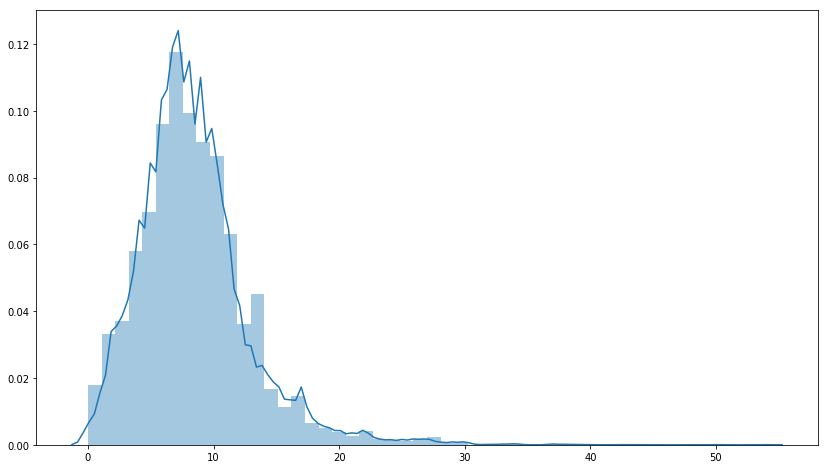

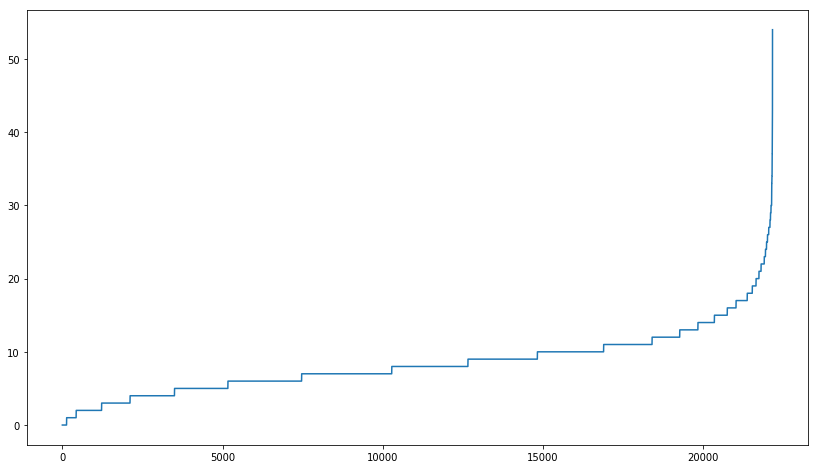

In [22]:
len_ans=np.array([sum((y_dat[sample]>0)*1) for sample in range(X_dat_preg.shape[0])])
plt.figure(figsize=(14,8))
sns.distplot(len_ans)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(range(len(len_ans)),len_ans[len_ans.sort()][0])
plt.show()
median_len_answers=len_ans[len_ans.sort()][0,[int((len(len_ans)/2)+(.5)),int((len(len_ans)/2)-(.5))]]

In [23]:
sample=np.random.randint(y_dat.shape[0])#X_dat_corr.shape[0])#4647

y_embd_3_preg=preg_expect(X_dat_preg[sample],y_emb_ocurrs_preg_resp)
y_embd_3_refans=preg_expect(X_dat_refans[sample],y_emb_ocurrs_refans_respest)
print(sample)
calif[sample]

5190


0

In [24]:
train_answers.iloc[sample]

dtset                                                TRAIN Beetle
qtype                                          Q_EXPLAIN_SPECIFIC
stype                                                    EVALUATE
quest_id                              BULB_C_VOLTAGE_EXPLAIN_WHY1
question        Explain why you got a voltage reading of 1.5 f...
ref_ans         Terminal 1 and the positive terminal are not c...
st_answ         Voltage is the difference between a positive a...
id_st           FaultFinding-BULB_C_VOLTAGE_EXPLAIN_WHY1.sbj35...
st_ans_calif                                                    0
Name: 5190, dtype: object

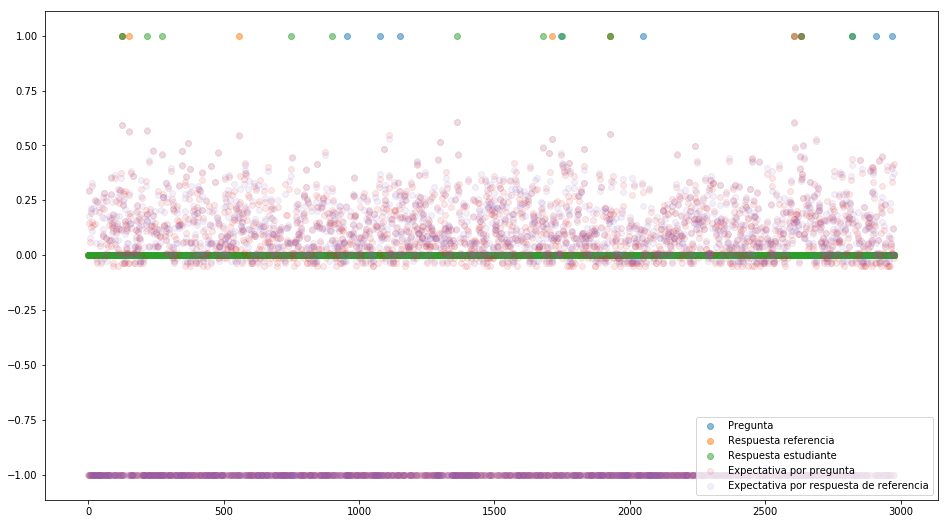

In [25]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)


ax.scatter(x=range(len(y_dat[sample])),
            y=(X_dat_preg[sample]>0)*1, alpha=.5, label="Pregunta")
ax.scatter(x=range(len(y_dat[sample])),
            y=(X_dat_refans[sample]>0)*1,alpha=.5, label="Respuesta referencia")
ax.scatter(x=range(len(y_dat[sample])),
            y=(y_dat[sample]>0)*1,alpha=.5, label="Respuesta estudiante")
ax.scatter(x=range(len(y_dat[sample])),
            y=y_embd_3_preg, alpha=.1, label="Expectativa por pregunta")
ax.scatter(x=range(len(y_dat[sample])),
            y=y_embd_3_refans, alpha=.1, label="Expectativa por respuesta de referencia")
plt.legend(loc='lower right')
plt.show()

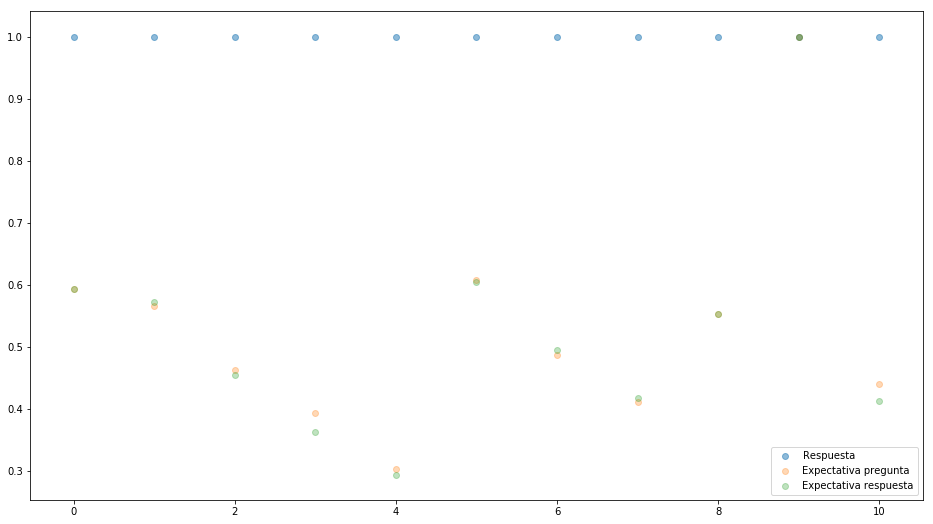

In [26]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

real_w=y_dat[sample][y_dat[sample]>0]
pred_pr=y_embd_3_preg[y_dat[sample]>0]
pred_rf=y_embd_3_refans[y_dat[sample]>0]


ax.scatter(x=range(len(real_w)),
            y=real_w, alpha=.5, label="Respuesta")
ax.scatter(x=range(len(real_w)),
            y=pred_pr, alpha=.3, label="Expectativa pregunta")
ax.scatter(x=range(len(real_w)),
            y=pred_rf, alpha=.3, label="Expectativa respuesta")

plt.legend(loc='lower right')
plt.show()

In [27]:
# pred_pr=y_embd_3_preg[y_dat[sample]>0]
# pred_rf=y_embd_3_refans[y_dat[sample]>0]

cos_dist,euclid_dist=dists_resp(train_preg_ref_X_info[sample],y_dat[sample],y_embd_3_preg)
print(cos_dist, "Distancia coseno expectativa pregunta")
print(euclid_dist, "Distancia euclideana expectativa pregunta")

cos_dist,euclid_dist=dists_resp(train_preg_ref_X_info[sample],y_dat[sample],y_embd_3_refans)
print(cos_dist, "Distancia coseno expectativa respuesta referencia")
print(euclid_dist, "Distancia euclideana respuesta referencia")

0.49146182391204785 Distancia coseno expectativa pregunta
2.722849242279801 Distancia euclideana expectativa pregunta
0.4994595592165324 Distancia coseno expectativa respuesta referencia
2.7376898964916494 Distancia euclideana respuesta referencia


In [28]:
coss_preg=[]
eucl_preg=[]
for sample in range(X_dat_preg.shape[0]):
#     print(sample)
    y_embd_sample=preg_expect(X_dat_preg[sample],y_emb_ocurrs_preg_resp)
    cos_dist,euclid_dist=dists_resp(X_dat_preg[sample],y_dat[sample],y_embd_sample)
    coss_preg.append(cos_dist)
    eucl_preg.append(euclid_dist)
coss_preg=np.array(coss_preg)
eucl_preg=np.array(eucl_preg)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distancia coseno expectativa de pregunta')

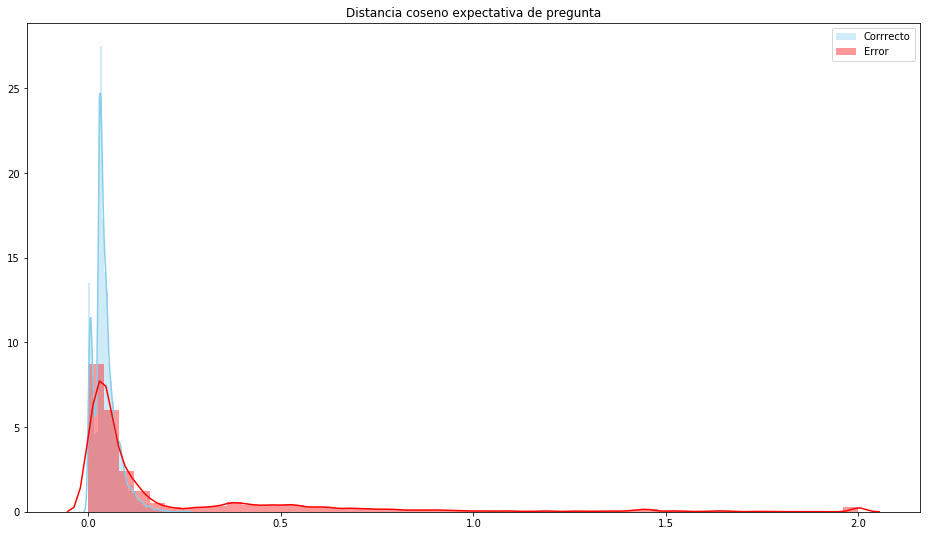

In [29]:
plt.figure(figsize=(16,9))
sns.distplot(coss_preg[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot(coss_preg[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia coseno expectativa de pregunta")

Text(0.5, 1.0, 'Distancia Euclideana expectativa de pregunta')

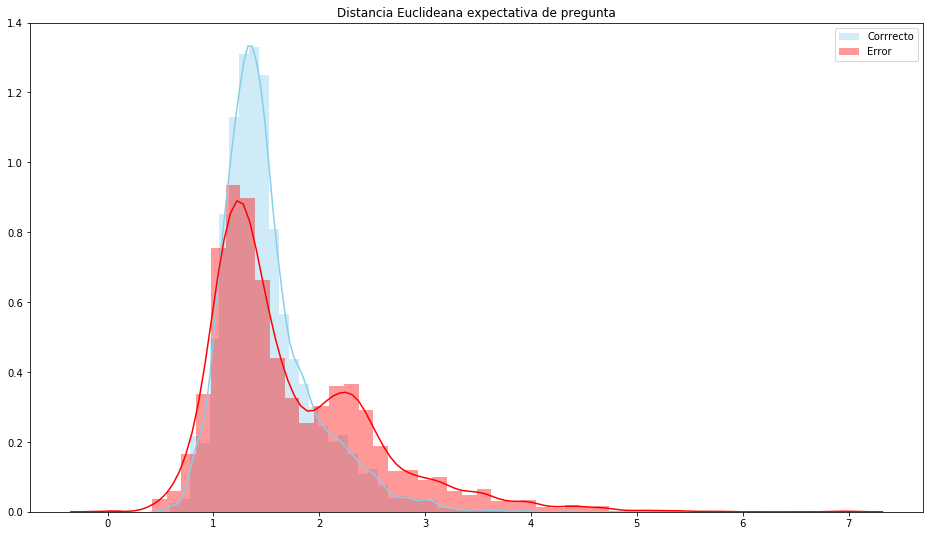

In [30]:
plt.figure(figsize=(16,9))
sns.distplot(eucl_preg[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot(eucl_preg[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia Euclideana expectativa de pregunta")

In [31]:
coss_refans=[]
eucl_refans=[]
for sample in range(X_dat_refans.shape[0]):
#     print(sample)
    y_embd_sample=preg_expect(X_dat_refans[sample],y_emb_ocurrs_refans_respest)
    cos_dist,euclid_dist=dists_resp(X_dat_refans[sample],y_dat[sample],y_embd_sample)
    coss_refans.append(cos_dist)
    eucl_refans.append(euclid_dist)
coss_refans=np.array(coss_refans)
eucl_refans=np.array(eucl_refans)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distancia coseno expectativa de respuesta de referencia')

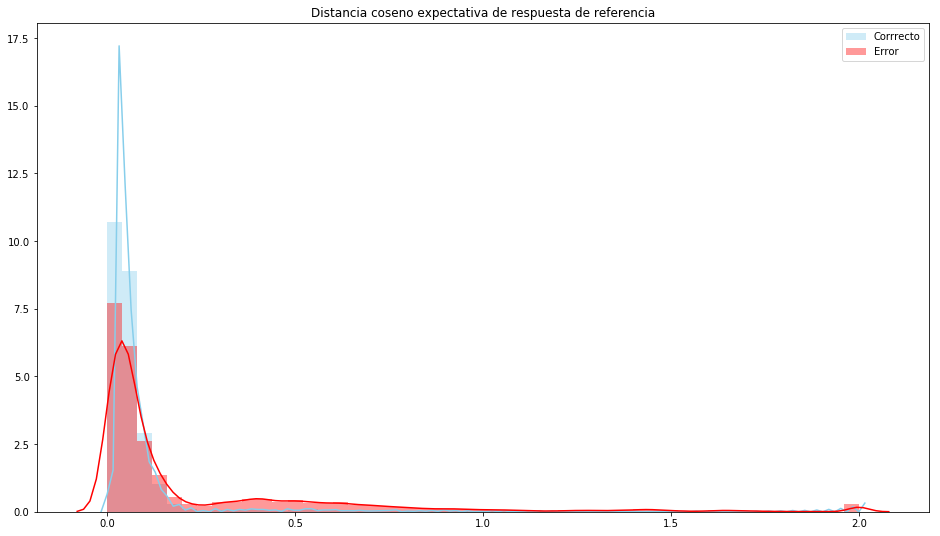

In [32]:
plt.figure(figsize=(16,9))
sns.distplot(coss_refans[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot(coss_refans[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia coseno expectativa de respuesta de referencia")

Text(0.5, 1.0, 'Distancia Euclideana expectativa de respuesta de referencia')

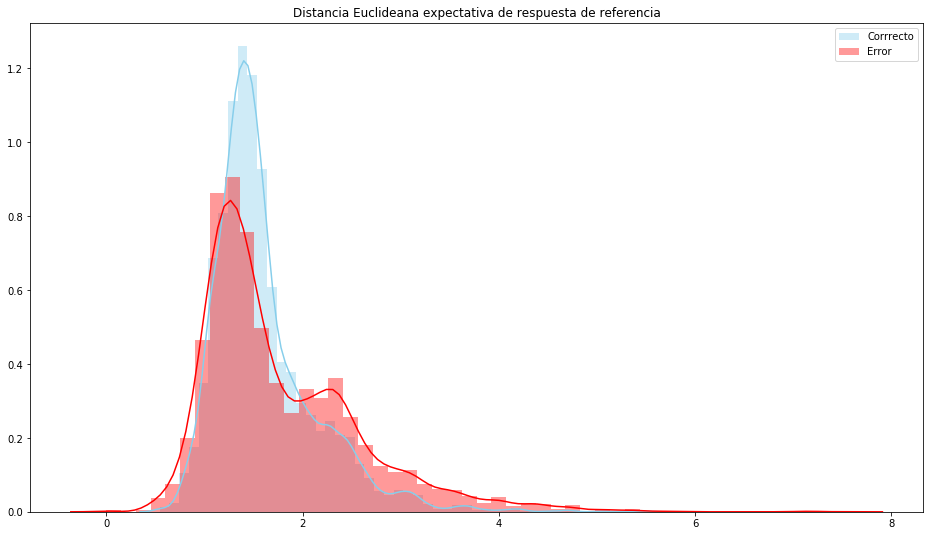

In [33]:
plt.figure(figsize=(16,9))
sns.distplot( eucl_refans[calif==1] , color="skyblue", label="Corrrecto")
sns.distplot( eucl_refans[calif==0] , color="red", label="Error")
plt.legend()
plt.title("Distancia Euclideana expectativa de respuesta de referencia")

Text(0.5, 1.0, 'Distancias Euclideana')

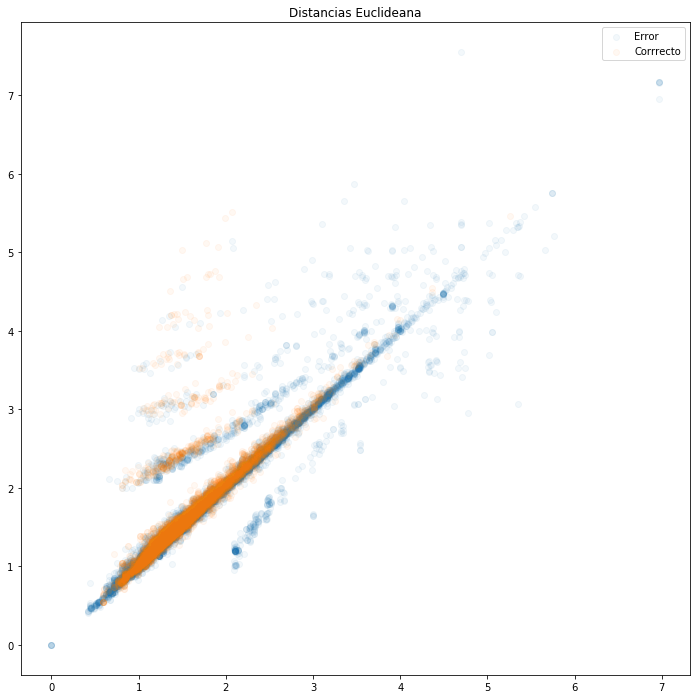

In [34]:
plt.figure(figsize=(12,12))
plt.scatter(eucl_preg[calif==0], eucl_refans[calif==0] , alpha=.05, label="Error")
plt.scatter(eucl_preg[calif==1], eucl_refans[calif==1] , alpha=.05, label="Corrrecto")
plt.legend()
plt.title("Distancias Euclideana")

Text(0.5, 1.0, 'Distancias Coseno')

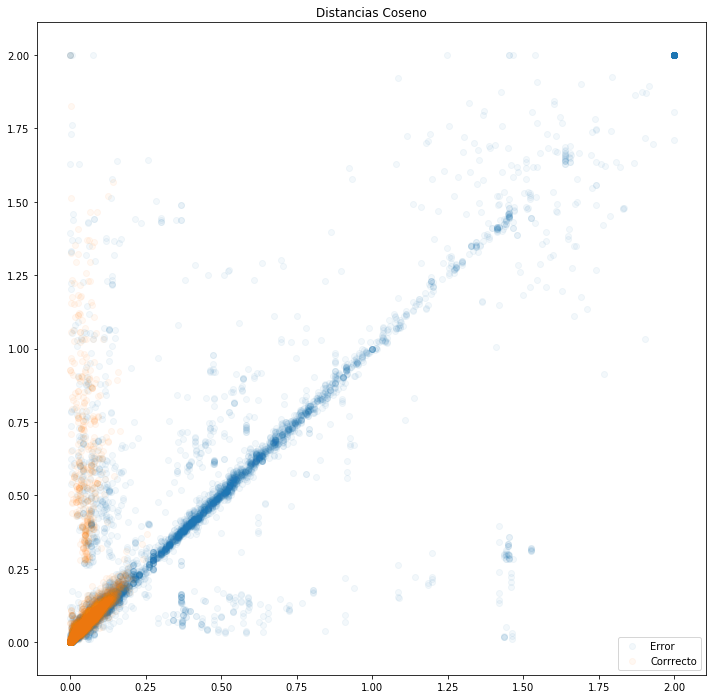

In [35]:
plt.figure(figsize=(12,12))
plt.scatter(coss_preg[calif==0], coss_refans[calif==0] , alpha=.05, label="Error")
plt.scatter(coss_preg[calif==1], coss_refans[calif==1] , alpha=.05, label="Corrrecto")
plt.legend()
plt.title("Distancias Coseno")

Text(0.5, 1.0, 'Distancia Coseno/Euclideana exepect pregunta')

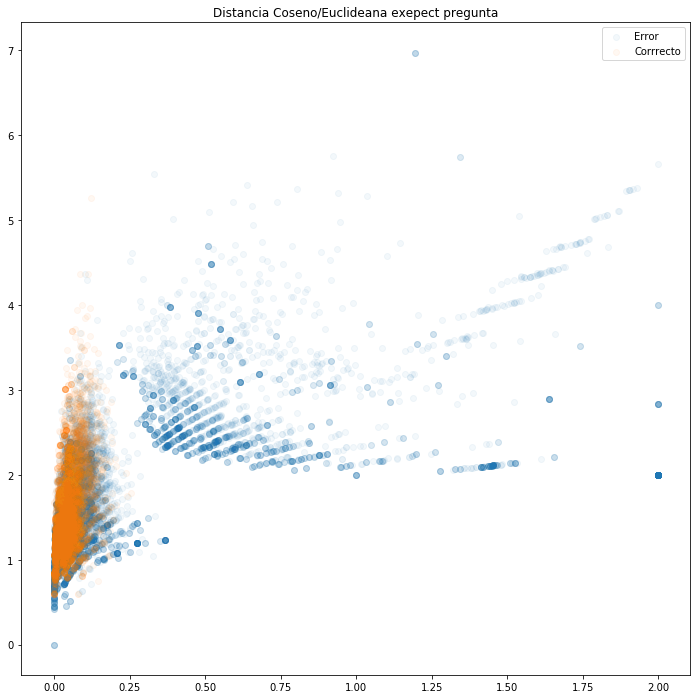

In [36]:
plt.figure(figsize=(12,12))
plt.scatter(coss_preg[calif==0], eucl_preg[calif==0] , alpha=.05, label="Error")
plt.scatter(coss_preg[calif==1], eucl_preg[calif==1] , alpha=.05, label="Corrrecto")
plt.legend()
plt.title("Distancia Coseno/Euclideana exepect pregunta")

Text(0.5, 1.0, 'Distancia Coseno/Euclideana exepect respuesta')

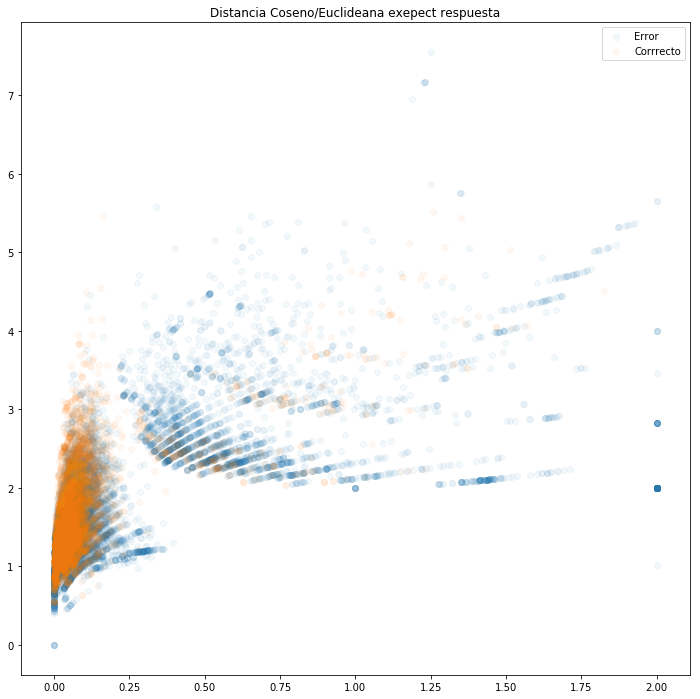

In [37]:
plt.figure(figsize=(12,12))
plt.scatter(coss_refans[calif==0], eucl_refans[calif==0], alpha=.05, label="Error")
plt.scatter(coss_refans[calif==1], eucl_refans[calif==1], alpha=.05, label="Corrrecto")
plt.legend()
plt.title("Distancia Coseno/Euclideana exepect respuesta")

Text(0.5, 1.0, 'Distancia Coseno expect pregunta /Euclideana exepect respuesta')

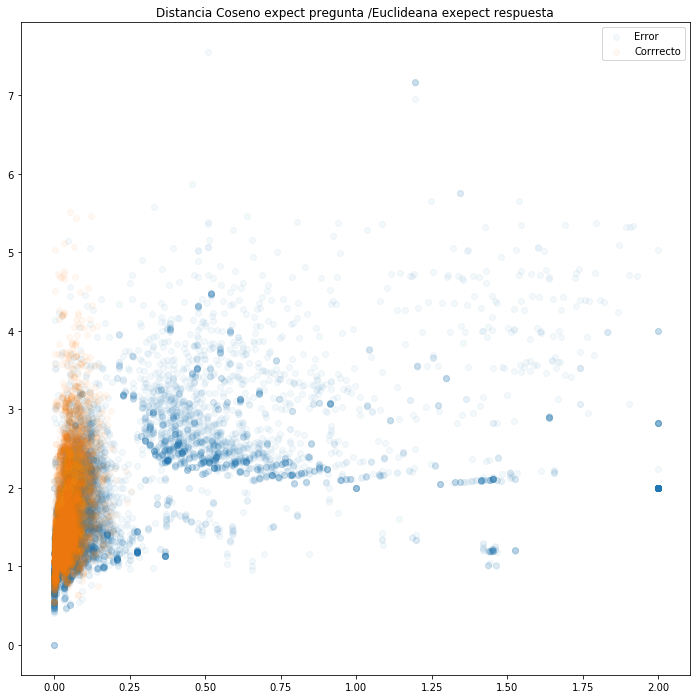

In [38]:
plt.figure(figsize=(12,12))
plt.scatter(coss_preg[calif==0], eucl_refans[calif==0] , alpha=.05, label="Error")
plt.scatter(coss_preg[calif==1], eucl_refans[calif==1] , alpha=.05, label="Corrrecto")
plt.legend()
plt.title("Distancia Coseno expect pregunta /Euclideana exepect respuesta")